In [ ]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(''))))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from src.Config import Config as cfg
from src.features.utils_data import Utils
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pickle
import torch
from functools import partial

In [62]:
from torchsummary import summary

In [46]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# We have to collect all files paths into one array according to folders, train and test
train_val_files = Utils.get_files_and_labels(cfg.TRAINING_FOLDER)
test_files = Utils.get_files_and_labels(cfg.TESTING_FOLDER)

In [ ]:
# Now we need to split train images into validation and train parts
# Train and Validation data
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
# Calculate mean of images pixels
tensor_files = map(lambda file: Utils.my_mean(file, RESCALE_SIZE=cfg.RESCALE_SIZE), train_files)
color_sum = torch.zeros(3)
for image_color_sum in tensor_files:
    color_sum+=image_color_sum

means = color_sum/(cfg.RESCALE_SIZE*cfg.RESCALE_SIZE*len(train_files))

In [ ]:
MEANS = means
MEANS

tensor([0.1842, 0.1843, 0.1843])

In [14]:
# Calculate st of images pixels
tensor_files = map(lambda file: Utils.my_std(file, means=means, RESCALE_SIZE=cfg.RESCALE_SIZE), train_files)
varience_sum = torch.zeros(3)
for image_color_sum in tensor_files:
    varience_sum+=image_color_sum
std = (varience_sum/(len(train_files)))**0.5

In [15]:
STD = std
STD

tensor([0.2018, 0.2018, 0.2018])

In [16]:
from src.features.braindataset import BrainDataset 
from torchvision import models, transforms

In [17]:
# Normalisation of train data by mean and std
transforms_trainBase = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Grayscale(3),  # Convert to grayscale
    #transforms.GaussianBlur(kernel_size=(1, 1), sigma=(0.2, 0.2)),
    transforms.Resize(size=(cfg.RESCALE_SIZE, cfg.RESCALE_SIZE), antialias=False),
    #transforms.ColorJitter(brightness=0.1, contrast=0.6),
    transforms.Normalize(MEANS, STD)
])

In [18]:
transforms_val = transforms.Compose([
                transforms.Resize(size=(cfg.RESCALE_SIZE, cfg.RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(MEANS, STD)
            ])

In [19]:
# Dataset creation, we wrap files into special class
train_dataset = BrainDataset(train_files, mode='train', transforms_train = transforms_trainBase, transform_val_test = transforms_val)
val_dataset = BrainDataset(val_files, mode='val', transforms_train = transforms_trainBase, transform_val_test = transforms_val)
test_dataset = BrainDataset(test_files, mode='test', transforms_train = transforms_trainBase, transform_val_test = transforms_val)

In [20]:
#Check size of datasets
t = train_dataset.__len__()
print(t, 'train')
v = val_dataset.__len__()
print(v, 'val')
test = test_dataset.__len__()
print(test, 'test')

4140 train
1381 val
1205 test


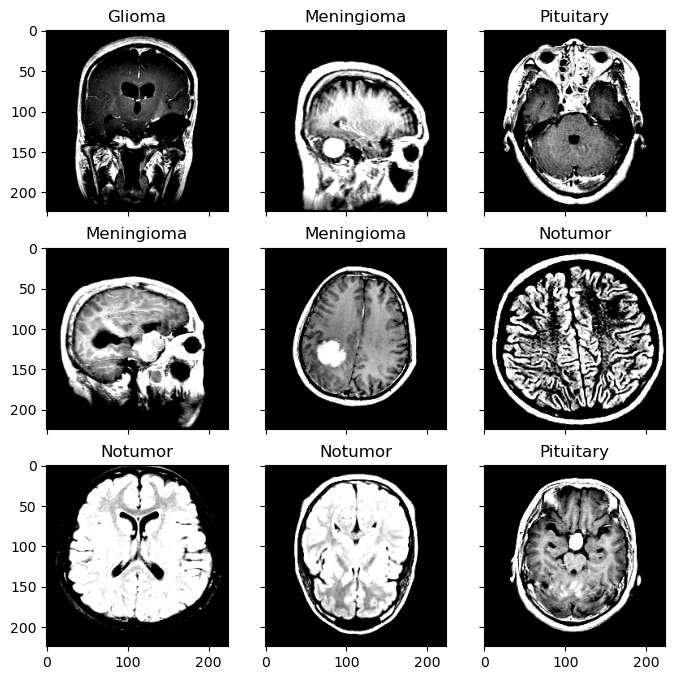

In [45]:

Utils.display_random_images(train_dataset)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE)

In [23]:
from tqdm import tqdm, tqdm_notebook
import torch.nn as nn

### ResNet50

In [65]:
torch.cuda.empty_cache()

In [25]:
n_classes = len(np.unique(cfg.CLASSES))
print("Number of classes: {}".format(n_classes))

Number of classes: 4


In [68]:
# Load a pretrained ResNet-50
if torch.cuda.is_available():
    model_resnet50 = models.resnet50().to(cfg.DEVICE)
    print('GPU')
else: 
    model_resnet50 = models.resnet50()

In [27]:
# Change the output features of the last layer
num_features = model_resnet50.fc.in_features

# Replace the last layer with a new linear layer
model_resnet50.fc = nn.Linear(num_features, n_classes)

In [28]:
#resnet50 = model_resnet50.to(DEVICE)
print("We will classify :{}".format(n_classes))
print(model_resnet50)

We will classify :4
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [29]:
epochs = 50
lr_curr = 0.001

In [30]:
#torch.optim.Adam(model_resnet50.parameters(), lr=lr_curr)
print(next(model_resnet50.parameters()).device)

cpu


In [31]:
def eval_epoch(model, val_loader, criterion, early_stopping, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    # Set model to evaluation mode to deactivate dropout
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(cfg.DEVICE)
            labels = labels.to(cfg.DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    # Early stopping
    if early_stopping:
        if early_stopping(val_loss):
            print("Early stopping triggered.")
            return val_loss, val_acc, True  # Signal for early stopping

    # Logging loss and accuracy
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_acc, epoch)

    return val_loss, val_acc, False  # Signal to continue training

In [32]:
def fit_epoch(model, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    # Set model to train mode to activate dropout
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(cfg.DEVICE)
        labels = labels.to(cfg.DEVICE)
        
        optimizer.zero_grad()
 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Accuracy/Training', train_acc, epoch)
    
    return train_loss, train_acc

In [33]:
def train(train_loader, val_loader, model, epochs, patience=3, delta=0.001):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    lr = 0.001
    
    early_stopping = EarlyStopping(patience=patience, min_delta=delta)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            lr_curr = lr/(1+epoch)
            opt = torch.optim.Adam(model.parameters(), lr=lr_curr)
            
            train_loss, train_acc = fit_epoch(model.to(cfg.DEVICE), train_loader, criterion, opt, epoch)
            print("loss", train_loss)
            
            val_loss, val_acc, stop_training = eval_epoch(model, val_loader, criterion, early_stopping, epoch)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # Progress bar displays the training loss and accuracy
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if stop_training:
                print("Early stopping triggered.")
                break

    return history

In [34]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            #inputs = inputs
            inputs = inputs.to(cfg.DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [35]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


In [36]:
history = train(train_loader, val_loader, model_resnet50, epochs, patience=5, delta=0.001)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 0.9444630808300443


epoch:   2%|▏         | 1/50 [20:00<16:20:16, 1200.35s/it]


Epoch 001 train_loss: 0.9445     val_loss 0.7364 train_acc 0.6459 val_acc 0.6836
loss 0.9240920175100871


epoch:   4%|▍         | 2/50 [7:42:19<214:44:12, 16105.26s/it]


Epoch 002 train_loss: 0.9241     val_loss 0.8401 train_acc 0.6444 val_acc 0.6401
loss 0.643103363663678


epoch:   6%|▌         | 3/50 [8:01:43<121:11:41, 9283.02s/it] 


Epoch 003 train_loss: 0.6431     val_loss 0.5736 train_acc 0.7546 val_acc 0.7705
loss 0.5225357330075785


epoch:   8%|▊         | 4/50 [8:20:08<77:21:44, 6054.45s/it] 


Epoch 004 train_loss: 0.5225     val_loss 0.4983 train_acc 0.7899 val_acc 0.7849
loss 0.4451464395016288


epoch:  10%|█         | 5/50 [8:38:41<53:24:24, 4272.54s/it]


Epoch 005 train_loss: 0.4451     val_loss 0.4088 train_acc 0.8222 val_acc 0.8414
loss 0.3753318241396964


epoch:  12%|█▏        | 6/50 [8:57:04<39:02:54, 3194.88s/it]


Epoch 006 train_loss: 0.3753     val_loss 0.3587 train_acc 0.8466 val_acc 0.8530
loss 0.3124115761495443


epoch:  14%|█▍        | 7/50 [9:15:16<29:56:48, 2507.19s/it]


Epoch 007 train_loss: 0.3124     val_loss 0.3335 train_acc 0.8751 val_acc 0.8740
loss 0.2754737381485925


epoch:  16%|█▌        | 8/50 [9:33:08<23:55:21, 2050.52s/it]


Epoch 008 train_loss: 0.2755     val_loss 0.3197 train_acc 0.8903 val_acc 0.8863
loss 0.21876116957209538


epoch:  18%|█▊        | 9/50 [9:51:49<20:02:33, 1759.84s/it]


Epoch 009 train_loss: 0.2188     val_loss 0.2805 train_acc 0.9152 val_acc 0.9030
loss 0.17845253888967533


epoch:  20%|██        | 10/50 [10:10:21<17:19:50, 1559.76s/it]


Epoch 010 train_loss: 0.1785     val_loss 0.2646 train_acc 0.9341 val_acc 0.9015
loss 0.1415958933874173


epoch:  22%|██▏       | 11/50 [10:33:13<16:16:30, 1502.33s/it]


Epoch 011 train_loss: 0.1416     val_loss 0.3211 train_acc 0.9466 val_acc 0.8820
loss 0.12311284552431769


epoch:  24%|██▍       | 12/50 [10:54:48<15:11:38, 1439.42s/it]


Epoch 012 train_loss: 0.1231     val_loss 0.2551 train_acc 0.9512 val_acc 0.9117
loss 0.098663722022756


epoch:  26%|██▌       | 13/50 [11:15:40<14:12:30, 1382.44s/it]


Epoch 013 train_loss: 0.0987     val_loss 0.2717 train_acc 0.9618 val_acc 0.9102
loss 0.07406782419533257


epoch:  28%|██▊       | 14/50 [11:38:03<13:42:18, 1370.51s/it]


Epoch 014 train_loss: 0.0741     val_loss 0.3436 train_acc 0.9710 val_acc 0.8950
loss 0.06286089435638186


epoch:  30%|███       | 15/50 [12:01:54<13:30:10, 1388.86s/it]


Epoch 015 train_loss: 0.0629     val_loss 0.3018 train_acc 0.9778 val_acc 0.9037
loss 0.03981087854500986


epoch:  32%|███▏      | 16/50 [12:24:18<12:59:20, 1375.32s/it]


Epoch 016 train_loss: 0.0398     val_loss 0.3040 train_acc 0.9872 val_acc 0.9182
loss 0.03620990926820497


epoch:  34%|███▍      | 17/50 [12:45:13<24:45:25, 2700.77s/it]

Early stopping triggered.

Epoch 017 train_loss: 0.0362     val_loss 0.3250 train_acc 0.9862 val_acc 0.9167
Early stopping triggered.


In [64]:
summary(model_resnet50, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [37]:
loss, acc, val_loss, val_acc = zip(*history)

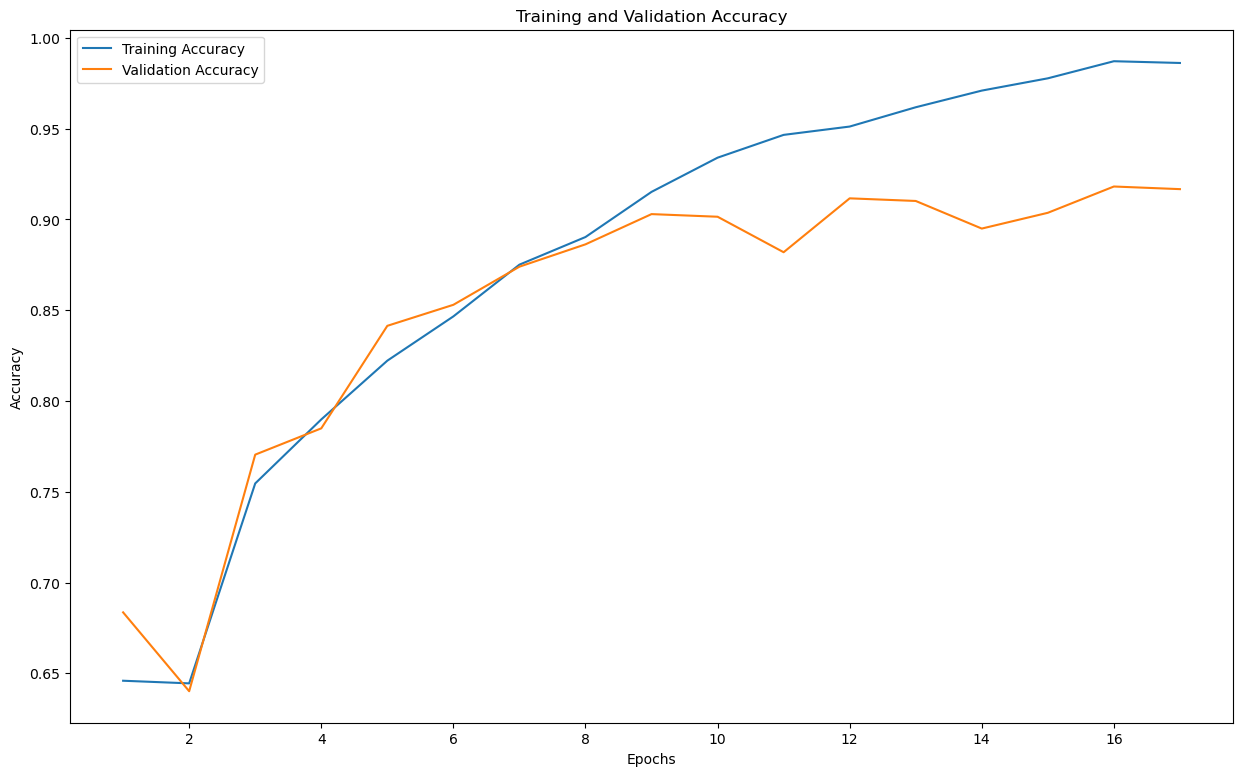

In [48]:
epochs = range(1, len(loss) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(15, 9))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

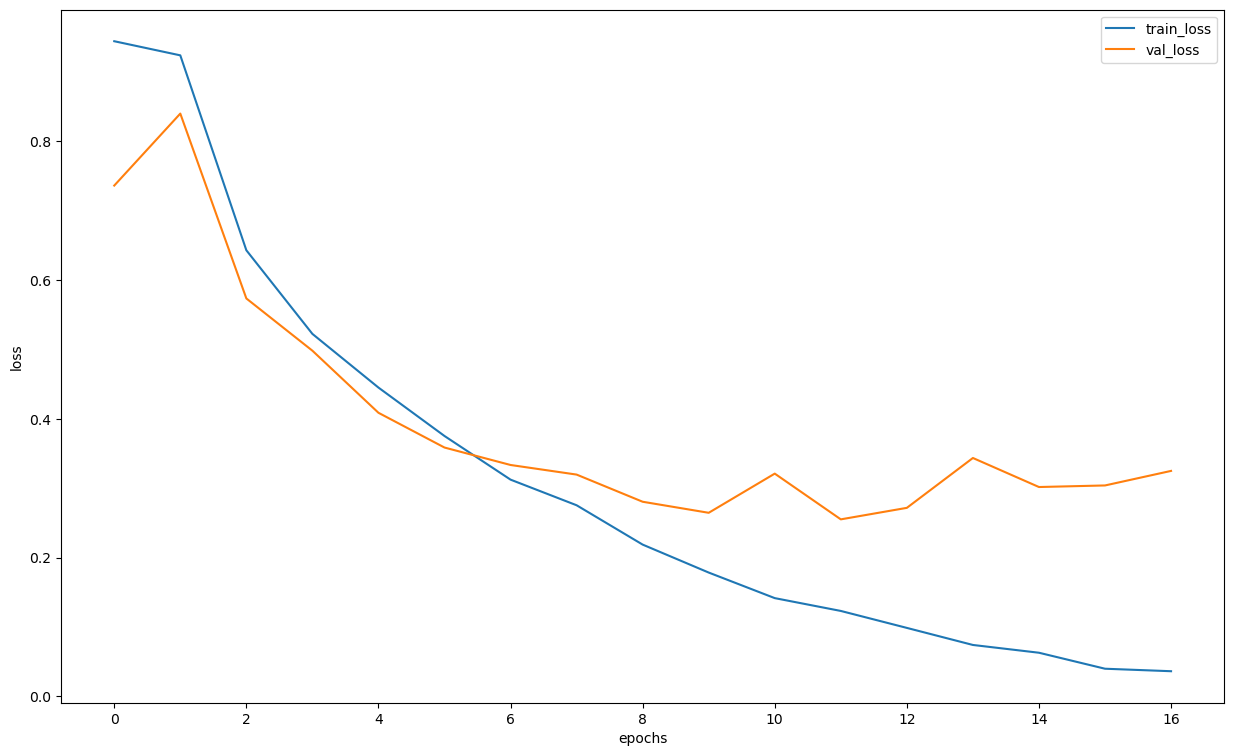

In [38]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [41]:
torch.save(model_resnet50.state_dict(), '../models/ResNet50/model_resnet50_baseline.pth')

In [71]:
# Print CUDA version
print("CUDA Version:", torch.version.cuda)

# Print PyTorch version
print("PyTorch Version:", torch.__version__)


CUDA Version: None
PyTorch Version: 2.2.1


In [73]:
torch.cuda.is_available()

False